In [1]:
import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import sbibm
import torch

import sys
sys.path.append("../../results/benchmarking_sbi/")
from utils import compile_df

# from sbibm.utils import compile_df
from sbibm.utils.io import get_tensor_from_csv, get_ndarray_from_csv
import pandas as pd
from sbi.analysis import pairplot

# Plotting settings
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.labelsize"] = "medium"
mpl.rcParams["xtick.labelsize"] = "small"
mpl.rcParams["ytick.labelsize"] = "small"
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.fontsize"] = 18
mpl.rcParams["font.size"] = 20
mpl.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Helvetica'})

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

seed 223174


## Load DDM task from `sbibm`

In [2]:
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

### Load pretrained LANs

In [3]:
# network trained on KDE likelihood for 4-param ddm
lan_kde_path = "../sbibm/algorithms/lan/lan_pretrained/model_final_ddm.h5"
lan_ana_path = "../sbibm/algorithms/lan/lan_pretrained/model_final_ddm_analytic.h5"
lan_kde = keras.models.load_model(lan_kde_path, compile=False)
lan_ana = keras.models.load_model(lan_ana_path, compile=False)

def lan_likelihood(theta, data, net, ll_lower_bound):
    """Return log likelihood summed over all trials in data, 
        given a batch of parameters theta.
    
    Args
        theta: batch of parameters
        data: batch of iid reaction times and choices encoded
            as negative and positive reaction times. 
        net: lan keras model
        ll_lower_bound: lower bound of single trial log likelihood.
        
    Returns
        llsum: batch of log likelihoods over trials. 
    """
    
    # Convert to positive rts.
    rts = abs(data)
    num_trials = rts.numel()
    num_parameters = theta.shape[0]
    assert rts.shape == torch.Size([num_trials, 1])
    theta = torch.tensor(theta, dtype=torch.float32)
    # Convert DDM boundary seperation to symmetric boundary size.
    theta[:, 1] *= 0.5

    # Code down -1 up +1.
    cs = torch.ones_like(rts)
    cs[data < 0] *= -1

    # Repeat theta trial times
    theta_repeated = theta.repeat(num_trials, 1)
    # repeat trial data theta times.
    rts_repeated = torch.repeat_interleave(rts, num_parameters, dim=0)
    cs_repeated = torch.repeat_interleave(cs, num_parameters, dim=0)

    # stack everything for the LAN net.
    theta_x_stack = torch.cat((theta_repeated, rts_repeated, cs_repeated), dim=1)
    ll_each_trial = torch.tensor(
        net.predict_on_batch(theta_x_stack.numpy()),
        dtype=torch.float32,
    ).reshape(num_trials, num_parameters)

    # Lower bound on each trial log likelihood.
    # Sum across trials.
    llsum = torch.where(
        torch.logical_and(
            rts.repeat(1, num_parameters) > theta[:, -1], 
            ll_each_trial > ll_lower_bound,
        ),
        ll_each_trial,
        ll_lower_bound * torch.ones_like(ll_each_trial),
    ).sum(0)
    
    return llsum

## Likelihood comparison for single example

##### Sample example parameter from prior

For creating a figure showing the likelihood over the entire data space given a fixed parameter combination we sample a single parameter combination from the prior and evaluate the synthetic likelihoods for a large range of reaction times and both choices, while holding the parameters fixed.

In [4]:
# Sample one parameter from the prior for a likelihood example.
theta_o = prior.sample((1,))
l_lower_bound = 1e-7
theta_o

tensor([[-0.1089,  1.0866,  0.6434,  1.3179]])

In [5]:
# Load pretrained NLE model
with open("../sbibm/algorithms/lan/nle_pretrained/mm_315_2.p", "rb") as fh: 
    nle = pickle.load(fh)

In [6]:
# construct rts and choices for nle in [-test_tmax, test_tmax]

# RT range
test_tmax = 5
# Number of test points
ntest = 1000
rs = torch.cat((torch.linspace(test_tmax, 1e-7, ntest//2), 
           torch.linspace(1e-7, test_tmax, ntest//2))).reshape(-1, 1)
cs = torch.cat((torch.zeros(ntest//2), 
           torch.ones(ntest//2))).reshape(-1, 1)

test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

# get NLE synthetic likelihood for each data point with fixed theta.
lps_nle = torch.tensor([nle.log_prob(r.reshape(-1, 1), c.reshape(-1, 1), theta_o) for r, c in zip(rs, cs)])

# from analytical likelihood
lps_true = torch.tensor([task.get_log_likelihood(theta_o, d.reshape(-1, 1), l_lower_bound=l_lower_bound) 
                     for d in test_rts])

# and from both LANs.
lps_lanana = torch.tensor([lan_likelihood(theta_o, 
                                   d.reshape(-1, 1), 
                                   net=lan_ana, 
                                   ll_lower_bound=np.log(l_lower_bound)) 
                    for d in test_rts])
lps_lankde = torch.tensor([lan_likelihood(theta_o, 
                                   d.reshape(-1, 1), 
                                   net=lan_kde, 
                                   ll_lower_bound=np.log(l_lower_bound)) 
                    for d in test_rts])

/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Systematic Likelihood comparison

Next we do a systematic comparison based on the Huber loss (the LAN training loss) and the mean squared error (MSE) between analytical and synthetic log likelihoods of LAN and NLE.

To mimick the inference setup we sample an observation from the simulator via parameters from the prior and obtain the likelihood of this observation given a large batch of parameters, e.g., `1000`, sampled from the prior. The Huber loss and MSE is then calculated across this batch, giving a single number. This procedure we repeat for many observation, e.g., `100` and then show boxplots over the resulting 100 numbers. 

In [7]:
# Define losses.
def huberloss(y, yhat):
    diff = abs(y-yhat)
    
    err = np.zeros(y.numel())
    err[diff <= 1.0] = 0.5 * diff[diff <= 1.0]**2
    err[diff > 1.0] = 0.5 + diff[diff > 1.0]
    return err.mean()

def mse(y, yhat):
    return torch.mean((y - yhat)**2)

In [8]:
# mimick the MCMC setting: xo is fixed, thetas are scored with loss
num_observations = 100
num_thetas_per_observation = 1000

# first sample observations xo
xos = simulator(prior.sample((num_observations,)))

labels = [
#     "LAN-ANA", 
    "LAN", 
    "NLE",
]
errors = []
for xoi in xos:
    
    # Sample test thetas from prior.
    test_thetas = prior.sample((num_thetas_per_observation,))
    xoi = xoi.reshape(-1, 1)
    # Extract positive RTs and choices for mixed model.
    rsi = abs(xoi)
    csi = torch.ones_like(rsi)
    csi[xoi < 0] = 0

    # Evaluate
    lps_nle_i = nle.log_prob(rsi, csi, test_thetas).squeeze()    
    lps_true_i = task.get_log_likelihood(test_thetas, data=xoi.reshape(1, -1), l_lower_bound=l_lower_bound)
    lps_lanana_i = lan_likelihood(test_thetas, xoi, lan_ana, np.log(l_lower_bound))
    lps_lankde_i = lan_likelihood(test_thetas, xoi, lan_kde, np.log(l_lower_bound))
    

    # Score
    errors.append([
            [
#                 huberloss(lps_lanana_i, lps_true_i),
                huberloss(lps_lankde_i, lps_true_i),
                huberloss(lps_nle_i, lps_true_i),
            ],
            [
#                 huberloss(lps_lanana_i.exp(), lps_true_i.exp()),
                huberloss(lps_lankde_i.exp(), lps_true_i.exp()),
                huberloss(lps_nle_i.exp(), lps_true_i.exp()),
            ],            
            [
#                 mse(lps_lanana_i, lps_true_i),
                mse(lps_lankde_i, lps_true_i),
                mse(lps_nle_i, lps_true_i),
            ], 
            [
#                 mse(lps_lanana_i.exp(), lps_true_i.exp()),
                mse(lps_lankde_i.exp(), lps_true_i.exp()),
                mse(lps_nle_i.exp(), lps_true_i.exp()),
            ],         
        ])
errors = np.array(errors)

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [9]:
# extract separate dataframes for huber and mse.
dfhuber_log = pd.DataFrame(data=np.array(errors)[:, 0, :], columns=labels)
dfhuber = pd.DataFrame(data=np.array(errors)[:, 1, :], columns=labels)
dfmse_log = pd.DataFrame(data=np.array(errors)[:, 2, :], columns=labels)
dfmse = pd.DataFrame(data=np.array(errors)[:, 3, :], columns=labels)

## Estimate evaluation times

In [10]:
import time
# Vary size of theta (number of MCMC chains in parallel)
num_chains = [10]
# Vary size of data (number of trials)
num_trials = [100]
reps = 100

lan_rts = np.zeros((len(num_chains), len(num_trials), reps))
nle_rts = np.zeros_like(lan_rts)

thetas = prior.sample((num_chains[-1],))
xs = simulator(prior.sample((1,)).repeat(num_trials[-1], 1))

for ii in range(reps):
    for jj, nc in enumerate(num_chains): 
        for kk, nt in enumerate(num_trials):
            # LAN timing
            tic = time.time()
            lan_likelihood(thetas[:nc,], xs[:nt,], net=lan_kde, ll_lower_bound=np.log(l_lower_bound))
            lan_rts[jj, kk, ii] = time.time() - tic

            # NLE timing
            rts = abs(xs[:nt])
            cs = torch.ones_like(rts)
            cs[xs[:nt] < 0] = 0
            tic = time.time()
            nle.log_prob(rts, cs, thetas[:nc])
            nle_rts[jj, kk, ii] = time.time() - tic

# convert ot ms
lan_rts *= 1000
nle_rts *= 1000

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [11]:
nle_rts.mean(), nle_rts.std()

(4.302823543548584, 0.2580698678063475)

In [12]:
lan_rts.mean(), lan_rts.std()

(5.300512313842773, 0.2758403941976225)

In [13]:
df_rt = pd.DataFrame(data={"LAN-KDE":lan_rts.reshape(-1), "NLE": nle_rts.reshape(-1)}, index=range(reps))

## Results figure 1

- likelihood examples

- likelihood accuracy

- number of simulations

- evaluation time

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


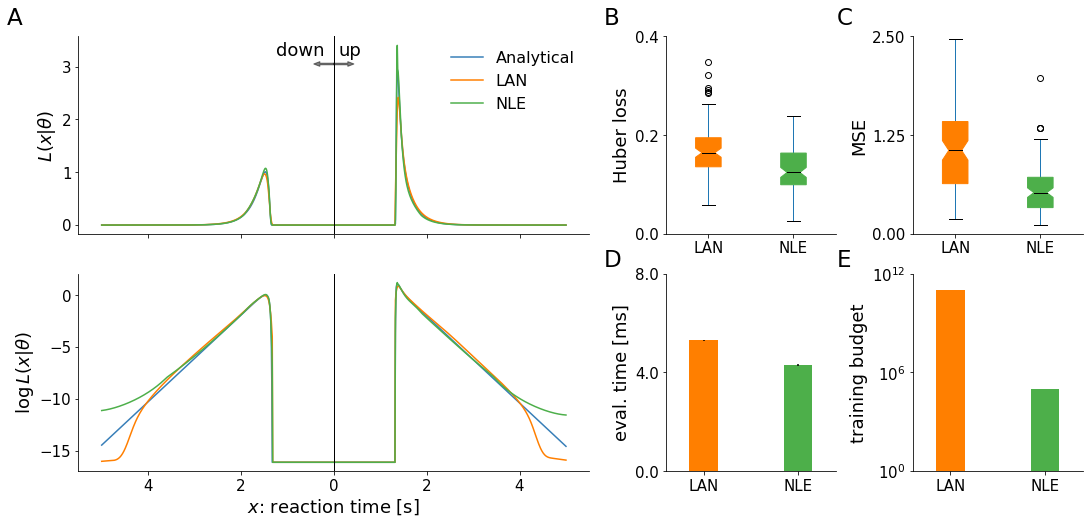

In [115]:
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(18, 8),  
                       gridspec_kw=dict(wspace=0.27, hspace=0.2, width_ratios=[0.6, .2, .2]))

grid = False
showfliers = True
mpl.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Helvetica'})

labels = ["Analytical", 
#           "LAN-ANA", 
          "LAN", 
          "NLE", 
         ]

plt.sca(ax[0, 0])
plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0]);
# plt.plot(test_rts, lps_lanana.exp(), label="LAN-ANA");
plt.plot(test_rts, lps_lankde.exp(), label="LAN-KDE", ls="-", c=colors[1]);
plt.plot(test_rts, lps_nle.exp(), label="NLE", ls="-", c=colors[2]);
plt.ylabel(r"$L(x | \theta)$");
plt.legend(labels)
plt.xticks([-4, -2, 0, 2, 4], [])
# plt.yticks([0, .4, .8, 1.2], [0, .4, .8, 1.2])
plt.axvline(0, color="k", lw=1)
y = max(lps_true.exp())+.1
plt.arrow(0, y, 0.3, 0., width=0.03, color="k", alpha=0.5)
plt.text(0.1, 1.05 * y, s="up")
plt.arrow(0, y, -0.3, 0., width=0.03, color="k", alpha=0.5)
plt.text(-1.25, 1.05*y, s="down")
# plt.yticks(np.linspace(0, 4, 5), np.linspace(0, 4, 5))
# plt.suptitle(fr"v={theta_o[0, 0]:.2f}, a={theta_o[0, 1]:.2f}, w={theta_o[0, 2]:.2f}, $\tau$={theta_o[0, 3]:.2f}");

plt.sca(ax[1, 0])
plt.plot(test_rts, lps_true, c=colors[0])
# plt.plot(test_rts, lps_lanana)
plt.plot(test_rts, lps_lankde, ls="-", c=colors[1])
plt.plot(test_rts, lps_nle, ls="-", c=colors[2])
# plt.legend(labels)
plt.xlabel("$x$: reaction time [s]")
plt.ylabel(r"$\log L(x | \theta)$");
plt.xticks([-4, -2, 0, 2, 4], [4, 2, 0, 2, 4])
plt.axvline(0, color="k", lw=1)


plt.sca(ax[0, 1])
box_widths = [0.3] * 2
bdict = dfhuber_log.boxplot(ax=ax[0, 1], patch_artist=True, return_type="dict", 
                        medianprops={"color": "k"}, grid=grid, 
                           notch=True, 
                           widths=box_widths, 
                           showfliers=showfliers,
                           )
plt.ylabel("Huber loss");
for i,box in enumerate(bdict['boxes']):
    box.set_color(colors[i+1])
plt.yticks(np.linspace(0, 0.4, 3));
plt.ylim(0, .4)

plt.sca(ax[0, 2])
bdict = dfmse_log.boxplot(ax=ax[0, 2], patch_artist=True, return_type="dict", 
                          medianprops={"color": "k"}, grid=grid, 
                          notch=True, 
                          widths=box_widths,
                          showfliers=showfliers,
                         )
plt.ylabel(r"MSE");
for i,box in enumerate(bdict['boxes']):
    box.set_color(colors[i+1])
plt.yticks(np.linspace(0, 2.5, 3))
plt.ylim(0, 2.5);


ddd = pd.DataFrame({'method': ["LAN", "NLE"], 'training budget': [1e11, 1e5]})
plt.sca(ax[1, 2])
ddd.plot.bar(x="method", y="training budget", color=colors[1:3], ax=ax[1, 2], 
             rot=0, width=box_widths[0])
plt.xlabel('')
plt.ylabel("training budget")
plt.legend("")
plt.yscale("log")
plt.ylim(5e4, 1e11)
plt.yticks(np.logspace(0, 12, 3), [r"$10^0$", 
                                   r"$10^6$", 
#                                    r"$10^6$",r"$10^7$",r"$10^8$",r"$10^9$", 
                                   r"$10^{12}$"])

ddd = pd.DataFrame({'method': ["LAN", "NLE"], 'rt': [lan_rts.mean(), nle_rts.mean()]})
plt.sca(ax[1, 1])
ddd.plot.bar(x="method", y="rt", color=colors[1:3], ax=ax[1, 1], 
             rot=0, width=box_widths[0], 
            yerr=[lan_rts.std()/np.sqrt(reps), nle_rts.std()/np.sqrt(reps)])
plt.xlabel('')
plt.ylabel("eval. time [ms]")
plt.legend("")
plt.yticks(np.linspace(0, 8, 3), np.linspace(0, 8, 3))

weight = "regular"
fontsize = 23
y1 = 0.9
x1 = 0.07
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.46, y1, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.64, y1, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.46, y1 - 0.42, "D", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.64, y1 - 0.42, "E", fontsize=fontsize, fontweight=weight);
plt.tight_layout()
fig.savefig("LAN-NLE-likelihood-comparison.png", dpi=300, bbox_inches="tight");

## Figure 2: posterior space

- posterior example
- posterior metrics, timings should be according to likelihood evaluation timings.

In [204]:
# df = pd.concat([
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-01/09-59-40/"),  # LAN 1-10
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-01/18-35-25/"),  # NLE 1-10
#     compile_df("../../results/benchmarking_sbi/multirun/2021-09-29/21-43-22/"),  # LAN 11-20
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-06/07-58-18/"),  # NLE 11-20
#     compile_df("../../results/benchmarking_sbi/multirun/2021-09-29/22-30-49/"),  # LAN 21-30
#     compile_df("../../results/benchmarking_sbi/multirun/2021-09-30/09-16-33/"),  # NLE 21-30
#     compile_df("../../results/benchmarking_sbi/multirun/2021-09-30/09-49-49/"),  # NLE 31-40
#     compile_df("../../results/benchmarking_sbi/multirun/2021-09-30/11-48-19/"),  # LaN 31-40
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/11-42-01/"),  # NLE 41-50
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/12-35-48/"),  # LaN 41-50
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/14-59-22/"),  # NLE 51-60
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/15-25-27/"),  # NLE 61-70
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/16-40-14/"),  # NLE 71-80
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/17-05-47/"),  # NLE 81-90
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/17-31-34/"),  # NLE 91-100
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/17-57-20/"),  # LAN 51-60
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/18-43-08/"),  # LAN 61-70
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/19-29-10/"),  # LAN 71-80
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/20-14-40/"),  # LAN 81-90
#     compile_df("../../results/benchmarking_sbi/multirun/2021-10-05/20-59-55/"),  # LAN 91-100
# ]
# );

df = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-25/11-01-18/"), # NLE 100, 1000
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-24/04-03-04/"), # LAN 100, 1000
])

df.num_observation = df.num_observation.astype(int)
df = df[df.num_observation <=300]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Calculate mean and variance erros post hoc

In [205]:
# get posterior sample mean and variance
N = 100
nle_samples = np.zeros((N, 10000, 4))
lan_samples = np.zeros((N, 10000, 4))
true_samples = np.zeros((N, 10000, 4))
true_params = np.zeros((N, 4))

for ii in range(N):
    obsi = ii + 1 + 200
    dd = df[df.num_observation==obsi]

    nle_samples[ii,] = get_ndarray_from_csv(dd[dd.algorithm=="NLE"].path.values[0]+"/posterior_samples.csv.bz2")
    lan_samples[ii,] = get_ndarray_from_csv(dd[dd.algorithm=="LAN-KDE"].path.values[0]+"/posterior_samples.csv.bz2")
    true_samples[ii,] = task.get_reference_posterior_samples(obsi).numpy()
    # get tho
    true_params[ii,] = task.get_true_parameters(obsi).numpy()

In [206]:
meanerr = np.zeros((N, 2))
varerr = np.zeros_like(meanerr)

meanerr[:, 1] = np.mean(abs(nle_samples.mean(-2) -true_samples.mean(-2)) / true_samples.std(-2), -1)
meanerr[:, 0] = np.mean(abs(lan_samples.mean(-2) -true_samples.mean(-2)) / true_samples.std(-2), -1)

varerr[:, 1] = np.mean(abs(nle_samples.var(-2)) / true_samples.var(-2), -1)
varerr[:, 0] = np.mean(abs(lan_samples.var(-2)) / true_samples.var(-2), -1)

In [207]:
df = df.sort_values(by=["num_observation", "algorithm"])
df.loc[:, "MEANERR"] = meanerr.reshape(-1)
df.loc[:, "VARERR"] = varerr.reshape(-1)

#### Load posterior samples

In [208]:
obs = 211
labels = ["LAN-KDE", "NLE"]
cols = ["MEANERR", "VARERR", "C2ST", "RT"]
paths = []

# df = df100
for alg in labels:
    idx = df[df.num_observation==obs].algorithm == alg
    p = df[df.num_observation==obs].loc[idx, "path"].values
    [paths.append(pi) for pi in p]

ss = [
    sbibm.get_task("ddm").get_reference_posterior_samples(obs)
     ] + [get_ndarray_from_csv(path+"/posterior_samples.csv.bz2") for path in paths]

print(sbibm.get_task("ddm").get_true_parameters(obs))

tensor([[-0.1677,  1.2243,  0.4250,  1.1840]])


/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


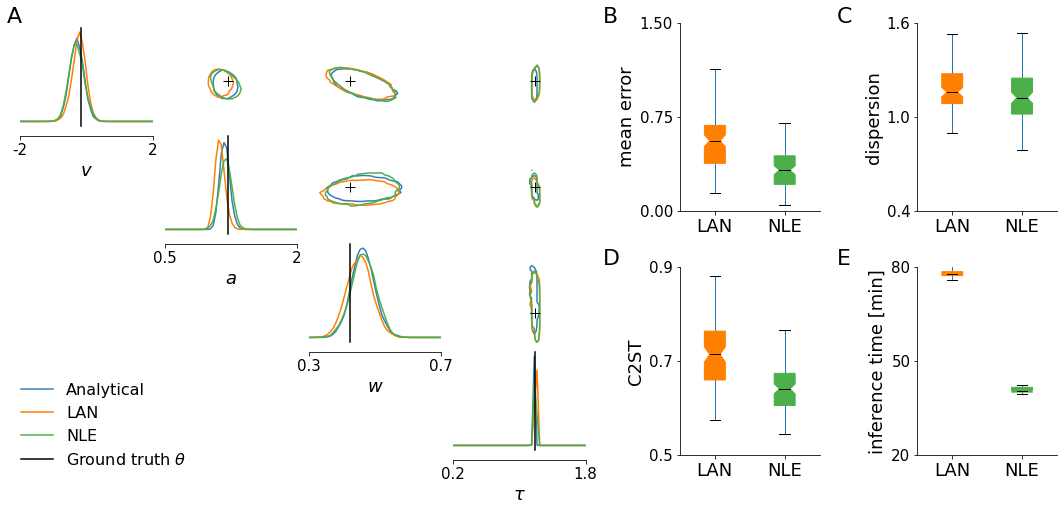

In [210]:
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=0.2, hspace=0, width_ratios=[.6, .4])
# Plotting settings
notch = True

# posterior samples
num_plots = 4
inner_grid = outer_grid[0, 0].subgridspec(num_plots, num_plots, wspace=0.09, hspace=0)
ax1 = inner_grid.subplots()  # Create all subplots for the inner grid.
pairplot(ss, 
         points=sbibm.get_task("ddm").get_true_parameters(obs), 
         limits=[[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]], 
         ticks = [[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]], 
         samples_colors=colors[:3], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method="scott", bins=50),
         contour_upper=dict(levels=[0.1], percentile=False),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         fig=fig, 
         axes=ax1,
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"],
        );
plt.sca(ax1[0, 0])
plt.legend(["Analytical", "LAN", "NLE", r"Ground truth $\theta$"], 
           bbox_to_anchor=(-.1, -2.2), 
           loc=2)


# posterior metrics
inner_grid = outer_grid[0, 1].subgridspec(2, 2, wspace=.7, hspace=.3, )
ax2 = inner_grid.subplots()  # Create all subplots for the inner grid.

bdict = df.boxplot(ax=ax2, column=cols, by=["algorithm"], rot=0, 
                grid=grid, 
                patch_artist=True,
                widths=box_widths,
                return_type="both", medianprops={"color": "k"}, 
                notch=notch, 
                showfliers=showfliers,);

ticks = [
    np.linspace(0, 1.5, 3), 
    np.linspace(0.4, 1.6, 3), 
    np.linspace(0.5, 0.9, 3),
    np.linspace(20, 80, 3),
]

for a, t in zip(ax2.reshape(-1), ticks):
    a.set_yticks(t)
    a.set_ylim(t[0], t[-1])


for row_key, (axi,row) in bdict.iteritems():
    for i,box in enumerate(row['boxes']):
        box.set_color(colors[i+1])
        
col_labels = ["mean error", "dispersion", "C2ST", "inference time [min]"]

for i, a in enumerate(ax2.reshape(-1)):
    a.set_ylabel(col_labels[i])
    a.set_title("")
    a.set_ylabel(col_labels[i])
    a.set_xlabel("")
    a.set_xticklabels(["LAN", "NLE"], fontsize=mpl.rcParams["font.size"])
plt.suptitle("")

weight = "regular"
fontsize = 22
y1 = 0.9
x1 = 0.09
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.46, y1, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.64, y1, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.46, y1 - 0.42, "D", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.64, y1 - 0.42, "E", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("LAN-NLE-posterior-comparison.png", dpi=300, bbox_inches="tight");

## Simulation-based calibration figure

## Compare posterior means: True vs LAN vs NLE

## Post-hoc SBC based on posterior samples

In [117]:
L = 1000
B = 5

ranks = np.zeros((N, 4, 3)) # 4 params, 3 methods

for obsi in range(N):
    # rank tho under samples
    ranks[obsi, :, 0] = (true_samples[obsi, :L, ] < true_params[obsi,]).sum(0)
    ranks[obsi, :, 1] = (lan_samples[obsi, :L, ] < true_params[obsi,]).sum(0)
    ranks[obsi, :, 2] = (nle_samples[obsi, :L, ] < true_params[obsi,]).sum(0)

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


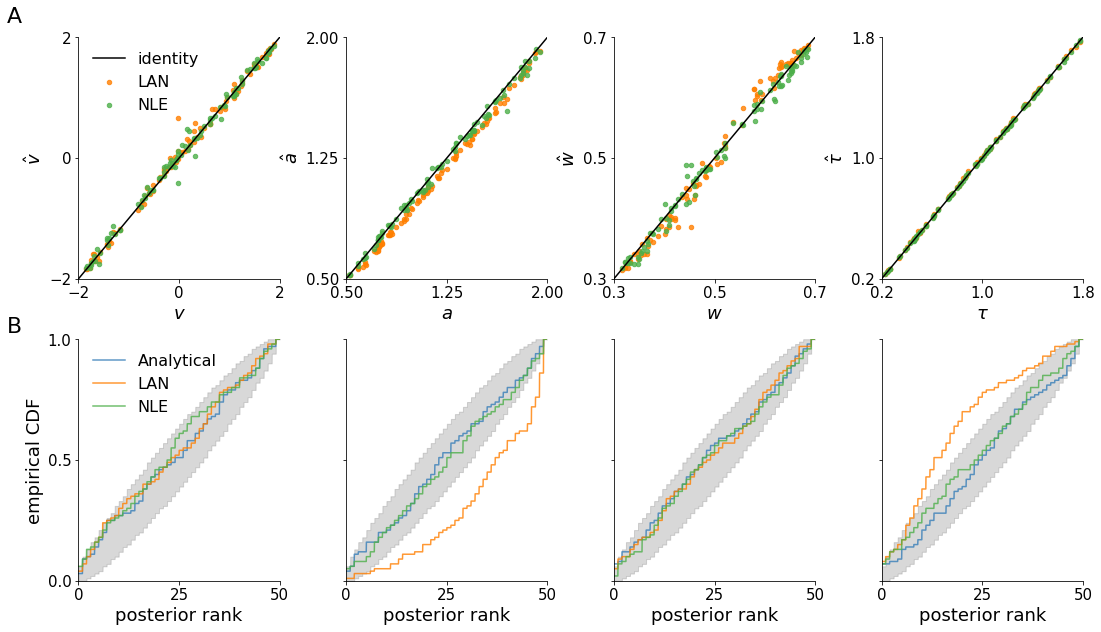

In [118]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10), 
                      gridspec_kw=dict(wspace=0.33, hspace=0.25))
mpl.rcParams["legend.fontsize"] = 16
s = 20
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]

for ii in range(4):
    truth = true_samples.mean(1)[:, ii]
#     truth = true_params[:, ii]
    plt.sca(ax[0, ii])
#     plt.scatter(truth, true_samples.mean(1)[:, ii], s=s, color="C0", label="True")
    plt.scatter(truth, lan_samples.mean(1)[:, ii], s=s, color=colors[1], 
#                 label=fr"LAN, $R^2={np.corrcoef(truth, lan_samples.mean(1)[:, ii])[0, 1]**2:.2f}$",
                label=fr"LAN",            
                alpha=alpha,
               )
    plt.scatter(truth, nle_samples.mean(1)[:, ii], s=s, color=colors[2], 
#                 label=fr"NLE, $R^2={np.corrcoef(truth, nle_samples.mean(1)[:, ii])[0, 1]**2:.2f}$",
                label=fr"NLE",
                alpha=alpha,                
               )
    plt.plot(np.linspace(limits[ii][0], limits[ii][1], 100), 
             np.linspace(limits[ii][0], limits[ii][1], 100), color="k", label="identity")
    plt.ylim(limits[ii])
    plt.yticks(np.linspace(limits[ii][0], limits[ii][1], 3))

    plt.xlim(limits[ii])
    plt.xticks(np.linspace(limits[ii][0], limits[ii][1], 3))
    plt.xlabel([r"$v$", r"$a$", r"$w$", r"$\tau$"][ii])
    plt.ylabel([r"$\hat{v}$", r"$\hat{a}$", r"$\hat{w}$", r"$\hat{\tau}$"][ii])
    if ii==0:
        plt.legend(loc=2);

bins = B
repeats = 50
nbins = 50
from scipy.stats import binom

for ii in range(3):
    for jj in range(4):
        plt.sca(ax[1, jj])
        hist, *_ = np.histogram(ranks[:, jj, ii], bins=nbins, density=False)
        histcs = hist.cumsum()
        plt.plot(np.linspace(0, nbins, repeats*nbins), 
                 np.repeat(histcs / histcs.max(), repeats), 
        #          label=labels[i], 
                 color=colors[ii], 
                 alpha=0.8)
        if jj==0:
            plt.yticks(np.linspace(0, 1, 3))
            plt.ylabel("empirical CDF")
            plt.legend(["Analytical", "LAN", "NLE"], loc=2)
        else:
            plt.yticks(np.linspace(0, 1, 3), [])
        plt.ylim(0, 1)
        plt.xlim(0, nbins)
        plt.xticks(np.linspace(0, nbins, 3))
        plt.xlabel("posterior rank")
        if ii==0:
            # Construct uniform histogram.
            hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
            hbb = hb.cumsum() / hb.sum()

            lower = [binom(N, p=p).ppf(0.005) for p in hbb]
            upper = [binom(N, p=p).ppf(0.995) for p in hbb]

            # Plot grey area with expected ECDF.
            plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                         y1=np.repeat(lower / np.max(lower), repeats), 
                         y2=np.repeat(upper / np.max(lower), repeats), 
                         color="grey", 
                         alpha=0.3)
weight = "regular"
fontsize = 22
y1 = 0.9
x1 = 0.07
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1 - 0.43, "B", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("LAN-NLE-calibration.png", dpi=300, bbox_inches="tight");

## Supplementary figure: synthetic data from NLE.

check out this commit or later:
a078720b50c275cc1c22cd9a5fab907b30a326c2

In [ ]:
num_examples = 3
fig, ax = plt.subplots(1, num_examples, figsize=(14, 4), sharex=False, sharey=False)
seed = 219793 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")
alpha = 0.7
show_likelihood = True

nbins = 100
num_samples = 10000
for i in range(num_examples):
    # Simulate
    tho = prior.sample((1,))
    tho[0, -1] = 0.2
    xo = simulator(tho.repeat(num_samples, 1))
    rt, cs = nle.sample(tho, num_samples)
    x = rt
    x[cs==0] *= -1
    
    # Likelihoods
    if show_likelihood:
        test_tmax = 2.
        # Number of test points
        ntest = 1000
        rs = torch.cat((torch.linspace(test_tmax, 1e-7, ntest//2), 
                   torch.linspace(1e-7, test_tmax, ntest//2))).reshape(-1, 1)
        cs = torch.cat((torch.zeros(ntest//2), 
                   torch.ones(ntest//2))).reshape(-1, 1)

        test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

        # get NLE synthetic likelihood for each data point with fixed theta.
        lps_nle = torch.tensor([nle.log_prob(r.reshape(-1, 1), c.reshape(-1, 1), tho) for r, c in zip(rs, cs)])

        # from analytical likelihood
        lps_true = torch.tensor([task.get_log_likelihood(tho, d.reshape(-1, 1), l_lower_bound=l_lower_bound) 
                             for d in test_rts])

    # Plotting
    plt.sca(ax if num_examples==1 else ax[i])
    c1, bins, _ = plt.hist(xo.numpy(), bins=nbins, alpha=alpha, label="simulator", 
                           color=colors[3], density=show_likelihood)
    c2, _, _ = plt.hist(x.numpy(), bins=bins, alpha=alpha, label="NLE", 
                        color=colors[2], density=show_likelihood)
    if show_likelihood:
        plt.plot(test_rts, lps_true.exp(), color="k", label=r"$L(x | \theta)$")

    if i == 0:
        plt.legend()
        plt.ylabel("density" if show_likelihood else "count")
    
    # fix yticks.
    maxcount = round(max(c1.max(), c2.max()), 1)
    if maxcount % 2: 
        maxcount += 1 
    plt.ylim(0, maxcount)
    plt.yticks(np.linspace(0, maxcount, 3))
    
    # xticks
    plt.xlabel("$x$: reaction time [s]")
    ticks = []
    bound = 2
    plt.xticks([-bound, 0, bound], [-bound, 0, bound])
    plt.xlim(-bound, bound)

y1 = 0.95
x1 = 0.01
# fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
# fig.text(x1 + .34, y1, "B", fontsize=fontsize, fontweight=weight)
# fig.text(x1 + .65, y1, "C", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("NLE-synthetic-data.png", dpi=300, bbox_inches="tight");

## Supplementary figure: posterior accuracy for different number of trials

### Post hoc SBC for all number of trials

In [124]:
df = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-22/17-54-20/"), # NLE 1, 10
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-22/21-43-48/"), # LAN 1, 10
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-23/10-17-26/"), # NLE 100, 1000. SEED 2
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-24/04-03-04/"), # LAN 100, 1000    
])


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10), 
                      gridspec_kw=dict(wspace=0.33, hspace=0.25))
mpl.rcParams["legend.fontsize"] = 16
s = 20
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]

for ii in range(4):
    truth = true_samples.mean(1)[:, ii]
#     truth = true_params[:, ii]
    plt.sca(ax[0, ii])
#     plt.scatter(truth, true_samples.mean(1)[:, ii], s=s, color="C0", label="True")
    plt.scatter(truth, lan_samples.mean(1)[:, ii], s=s, color=colors[1], 
#                 label=fr"LAN, $R^2={np.corrcoef(truth, lan_samples.mean(1)[:, ii])[0, 1]**2:.2f}$",
                label=fr"LAN",            
                alpha=alpha,
               )
    plt.scatter(truth, nle_samples.mean(1)[:, ii], s=s, color=colors[2], 
#                 label=fr"NLE, $R^2={np.corrcoef(truth, nle_samples.mean(1)[:, ii])[0, 1]**2:.2f}$",
                label=fr"NLE",
                alpha=alpha,                
               )
    plt.plot(np.linspace(limits[ii][0], limits[ii][1], 100), 
             np.linspace(limits[ii][0], limits[ii][1], 100), color="k", label="identity")
    plt.ylim(limits[ii])
    plt.yticks(np.linspace(limits[ii][0], limits[ii][1], 3))

    plt.xlim(limits[ii])
    plt.xticks(np.linspace(limits[ii][0], limits[ii][1], 3))
    plt.xlabel([r"$v$", r"$a$", r"$w$", r"$\tau$"][ii])
    plt.ylabel([r"$\hat{v}$", r"$\hat{a}$", r"$\hat{w}$", r"$\hat{\tau}$"][ii])
    if ii==0:
        plt.legend(loc=2);

bins = B
repeats = 50
nbins = 50
from scipy.stats import binom

for ii in range(3):
    for jj in range(4):
        plt.sca(ax[1, jj])
        hist, *_ = np.histogram(ranks[:, jj, ii], bins=nbins, density=False)
        histcs = hist.cumsum()
        plt.plot(np.linspace(0, nbins, repeats*nbins), 
                 np.repeat(histcs / histcs.max(), repeats), 
        #          label=labels[i], 
                 color=colors[ii], 
                 alpha=0.8)
        if jj==0:
            plt.yticks(np.linspace(0, 1, 3))
            plt.ylabel("empirical CDF")
            plt.legend(["Analytical", "LAN", "NLE"], loc=2)
        else:
            plt.yticks(np.linspace(0, 1, 3), [])
        plt.ylim(0, 1)
        plt.xlim(0, nbins)
        plt.xticks(np.linspace(0, nbins, 3))
        plt.xlabel("posterior rank")
        if ii==0:
            # Construct uniform histogram.
            hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
            hbb = hb.cumsum() / hb.sum()

            lower = [binom(N, p=p).ppf(0.005) for p in hbb]
            upper = [binom(N, p=p).ppf(0.995) for p in hbb]

            # Plot grey area with expected ECDF.
            plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                         y1=np.repeat(lower / np.max(lower), repeats), 
                         y2=np.repeat(upper / np.max(lower), repeats), 
                         color="grey", 
                         alpha=0.3)
weight = "regular"
fontsize = 22
y1 = 0.9
x1 = 0.07
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1 - 0.43, "B", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("LAN-NLE-calibration.png", dpi=300, bbox_inches="tight");

In [125]:
# get posterior sample mean and variance
task = sbibm.get_task("ddm")
N = 99
num_trials_list = [1, 10, 100, 1000]
invalid_seeds = [75]
nle_samples = np.zeros((len(num_trials_list), N, 10000, 4))
lan_samples = np.zeros((len(num_trials_list), N, 10000, 4))
true_samples = np.zeros((len(num_trials_list), N, 10000, 4))
true_params = np.zeros((len(num_trials_list), N, 4))
meanerr = np.zeros((len(num_trials_list), N, 2))
varerr = np.zeros_like(meanerr)
idx = 0

for seed in range(N+len(invalid_seeds)):
    
    if seed not in invalid_seeds:
        for ii in range(len(num_trials_list)):

            obsi = seed+1+ii*100
            dd = df[df.num_observation==obsi]
            nle_samples[ii, idx,] = get_ndarray_from_csv(dd[dd.algorithm=="NLE"].path.values[0]+"/posterior_samples.csv.bz2")
            lan_samples[ii, idx,] = get_ndarray_from_csv(dd[dd.algorithm=="LAN-KDE"].path.values[0]+"/posterior_samples.csv.bz2")
            true_samples[ii, idx,] = task.get_reference_posterior_samples(obsi).numpy()
            # get tho
            true_params[ii, idx,] = task.get_true_parameters(obsi).numpy()

        idx += 1

In [126]:
meanerr[:, :, 0] = np.mean((nle_samples.mean(-2) -true_samples.mean(-2)) / true_samples.std(-2), -1)
meanerr[:, :, 1] = np.mean((lan_samples.mean(-2) -true_samples.mean(-2)) / true_samples.std(-2), -1)

varerr[:, :, 0] = np.mean(abs(nle_samples.var(-2) / true_samples.var(-2)), -1)
varerr[:, :, 1] = np.mean(abs(lan_samples.var(-2) / true_samples.var(-2)), -1)

In [181]:
true_params.shape

(4, 99, 4)

In [184]:
## Post-hoc SBC based on posterior samples
L = 1000
B = 5

ranks = np.zeros((len(num_trials_list), N, 4, 3)) # different trial settings, N, 4 params, 3 methods

thos = prior.sample((N,))

for obsi in range(N):
    for ti in range(len(num_trials_list)):
        # rank tho under samples
        ranks[ti, obsi, :, 0] = (true_samples[ti, obsi, :L, ] < true_params[ti, obsi,]).sum(0)
        ranks[ti, obsi, :, 1] = (lan_samples[ti, obsi, :L, ] < true_params[ti, obsi,]).sum(0)
        ranks[ti, obsi, :, 2] = (nle_samples[ti, obsi, :L, ] < true_params[ti, obsi,]).sum(0)

# Correlation over posterior means.
corrs = np.zeros((4, 3, 4))
corrs[:, 2, ] = [[np.corrcoef(nle_samples[jj, :, :, ii].mean(1), 
                           true_params[jj, :, ii])[0, 1] for ii in range(4)] for jj in range(4)]
corrs[:, 1, ] = [[np.corrcoef(lan_samples[jj, :, :, ii].mean(1), 
                           true_params[jj, :, ii])[0, 1] for ii in range(4)] for jj in range(4)]
corrs[:, 0, ] = [[np.corrcoef(true_samples[jj, :, :, ii].mean(1), 
                           true_params[jj, :, ii])[0, 1] for ii in range(4)] for jj in range(4)]

In [194]:
corrs.mean(-1)[:, 0]

array([0.49581974, 0.87134411, 0.97864535, 0.99776185])

In [129]:
df["num_trials"] = 1
df = df[np.logical_not(df.algorithm == "LAN-ANA")]
df.num_observation = df.num_observation.astype(int)
df.algorithm[df.algorithm=="LAN-KDE"] = "LAN"
df.loc[df.num_observation <= 100, "num_trials"] = 1
df.loc[df.num_observation > 100, "num_trials"] = 10
df.loc[df.num_observation > 200, "num_trials"] = 100
df.loc[df.num_observation > 300, "num_trials"] = 1000

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [130]:
df = df.sort_values(by="num_observation")
mask = np.logical_or(
    np.logical_or(np.logical_or(df.num_observation == 76, df.num_observation == 176), 
                  df.num_observation == 276), 
    df.num_observation == 376)

# mask = df.num_observation > 300
df = df[~mask]

df.loc[:, "MEANERR"] = meanerr.reshape(-1)
df.loc[:, "VARERR"] = varerr.reshape(-1)

## Parameter recovery plot

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


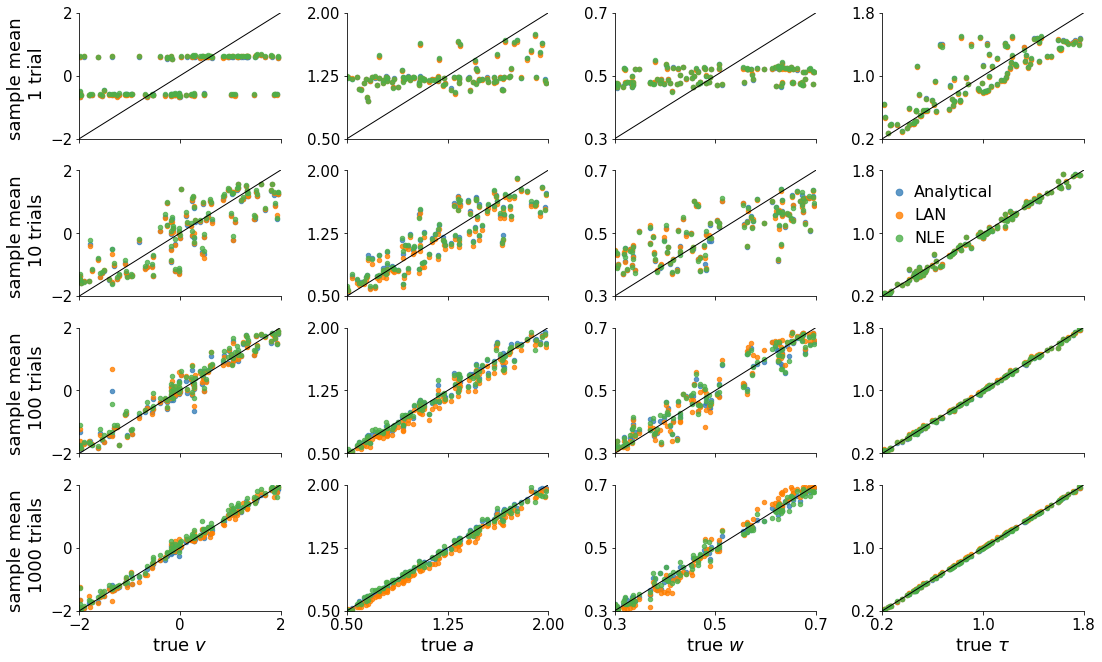

In [179]:
fig, ax = plt.subplots(4, 4, figsize=(18, 11), 
                      gridspec_kw=dict(wspace=0.33, hspace=0.25), sharex="col")
mpl.rcParams["legend.fontsize"] = 16
s = 20
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]

for jj in range(4):
    for ii in range(4):
#         truth = true_samples.mean(2)[jj, :, ii]
        truth = true_params[jj, :, ii]
        plt.sca(ax[jj, ii])
        plt.scatter(truth, true_samples.mean(2)[jj, :, ii], s=s, color=colors[0], 
                    label=fr"Analytical",            
                    alpha=alpha,
                   )
        plt.scatter(truth, lan_samples.mean(2)[jj, :, ii], s=s, color=colors[1], 
                    label=fr"LAN",            
                    alpha=alpha,
                   )
        plt.scatter(truth, nle_samples.mean(2)[jj, :, ii], s=s, color=colors[2], 
                    label=fr"NLE",
                    alpha=alpha,                
                   )
        plt.plot(np.linspace(limits[ii][0], limits[ii][1], 100), 
                 np.linspace(limits[ii][0], limits[ii][1], 100), color="k", lw=1)
        plt.ylim(limits[ii])
        plt.yticks(np.linspace(limits[ii][0], limits[ii][1], 3))

        plt.xlim(limits[ii])
        plt.xticks(np.linspace(limits[ii][0], limits[ii][1], 3))
        if jj==3:
            plt.xlabel("true " + [r"$v$", r"$a$", r"$w$", r"$\tau$"][ii])
        
        if ii==0:
            plt.ylabel(f"sample mean \n {[1, 10, 100, 1000][jj]} trial{'s' if jj>0 else ''}")
        if ii==3 and jj==1:
            plt.legend(loc=2, markerscale=1.5, handlelength=0.3, frameon=False);

plt.tight_layout();
fig.savefig("parameter-recovery-trials.png", dpi=300, bbox_inches="tight");

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


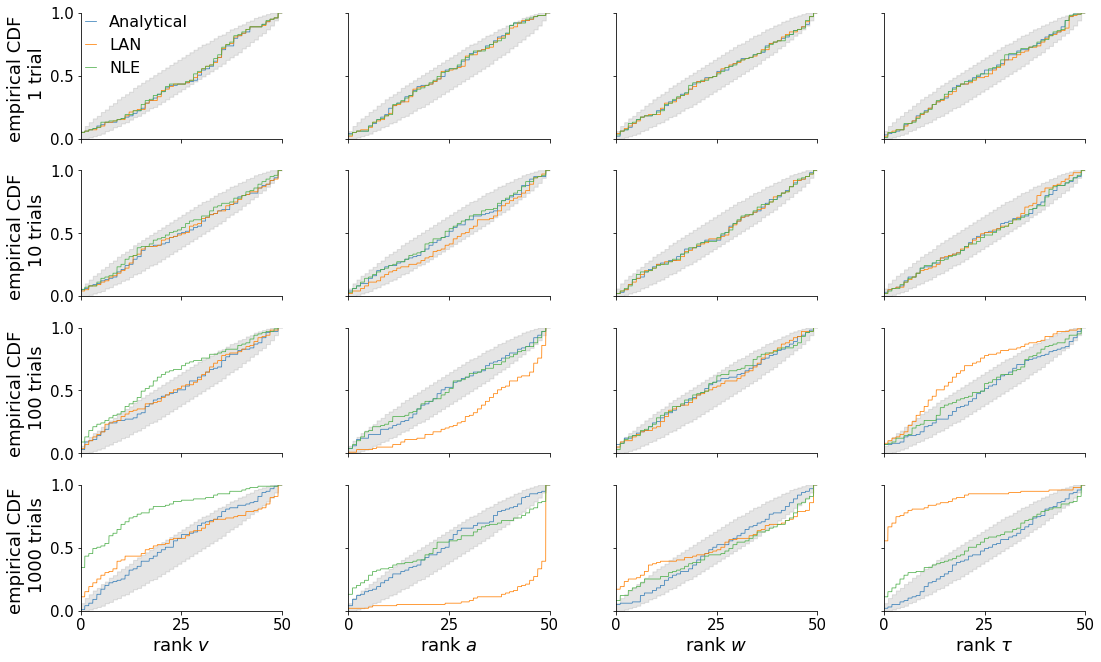

In [193]:
fig, ax = plt.subplots(4, 4, figsize=(18, 11), 
                      gridspec_kw=dict(wspace=0.33, hspace=0.25), sharex="col", sharey=True)
mpl.rcParams["legend.fontsize"] = 16
s = 20
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]

for kk in range(len(num_trials_list)):
    for ii in range(3):
        for jj in range(4):
            plt.sca(ax[kk, jj])
            hist, *_ = np.histogram(ranks[kk, :, jj, ii], bins=nbins, density=False)
            histcs = hist.cumsum()
            plt.plot(np.linspace(0, nbins, repeats*nbins), 
                     np.repeat(histcs / histcs.max(), repeats), 
                     label=labels[ii], 
                     color=colors[:3][ii], 
                     alpha=1., 
                     lw=.75)
            if jj==0:
                plt.yticks(np.linspace(0, 1, 3))
                plt.ylabel(f"empirical CDF \n {[1, 10, 100, 1000][kk]} trial{'s' if kk>0 else ''}")
                if kk == 0:
                    plt.legend(loc=2, markerscale=1.0, handlelength=0.7, bbox_to_anchor=(-.05, 1.1))
            else:
                plt.yticks(np.linspace(0, 1, 3), np.linspace(0, 1, 3))
            plt.ylim(0, 1)
            plt.xlim(0, nbins)
            plt.xticks(np.linspace(0, nbins, 3))
            if kk == 3:
                plt.xlabel("rank " + [r"$v$", r"$a$", r"$w$", r"$\tau$"][jj])
            if ii==0:
                # Construct uniform histogram.
                hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
                hbb = hb.cumsum() / hb.sum()

                lower = [binom(N, p=p).ppf(0.005) for p in hbb]
                upper = [binom(N, p=p).ppf(0.995) for p in hbb]

                # Plot grey area with expected ECDF.
                plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                             y1=np.repeat(lower / np.max(lower), repeats), 
                             y2=np.repeat(upper / np.max(lower), repeats), 
                             color="grey", 
                             alpha=0.2)

plt.tight_layout();
fig.savefig("sbc-over-trials.png", dpi=300, bbox_inches="tight");

## SBC with NLE ensembles over 5 seeds

In [235]:
dflan = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-22/21-43-48/"), # LAN 1, 10
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-24/04-03-04/"), # LAN 100, 1000    
])

dfnle0 = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-27/19-12-02/"), # NLE all but 6. SEED 0
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-28/18-43-19/"), # NLE rest. SEED 0
])
dfnle3 = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-11-02/14-37-00/"), # NLE all. SEED 3
])
dfnle2 = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-22/17-54-20/"), # NLE 1, 10
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-23/10-17-26/"), # NLE 100, 1000. SEED 2
])
dfnle1 = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-11-03/23-38-29/"), # NLE all. SEED 1
])
dfnle4 = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-29/00-40-46/"), # NLE 1, 10. SEED 4
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-25/11-01-18/"), # NLE 100, 1000. SEED 4
])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [236]:
# get posterior sample mean and variance
N = 99
M = 10000
ensembles = [
             dfnle0, 
             dfnle1, 
             dfnle2, 
             dfnle3, 
             dfnle4
            ]
num_ensembles = len(ensembles)

num_trials_list = [1, 10, 100, 1000]
# Exclude observations, e.g., when for one number of trials a run failed. 
invalid_seeds = [75]
nle_samples = np.zeros((len(num_trials_list), N, M, 4))
nlee_samples = np.zeros_like(nle_samples)
lan_samples = np.zeros_like(nle_samples)
true_samples = np.zeros_like(nle_samples)
true_params = np.zeros((len(num_trials_list), N, 4))
meanerr = np.zeros((len(num_trials_list), N, 3))
varerr = np.zeros_like(meanerr)
idx = 0

for seed in range(N+len(invalid_seeds)):
    
    if seed not in invalid_seeds:
        for ii in range(len(num_trials_list)):
            obsi = seed+1+ii*100
            
            # get samples from nle ensembles.
            nle_ensemble = np.zeros((M, 4, num_ensembles))
            for jj, df_ens in enumerate(ensembles):
                dd = df_ens[df_ens.num_observation==obsi]
                nle_ensemble[:, :, jj] = get_ndarray_from_csv(dd.path.values[0]+"/posterior_samples.csv.bz2")
            # select samples from ensembles with equal weights.
            nlee_samples[ii, idx,] = nle_ensemble[torch.arange(M), :, torch.randint(num_ensembles, (M,))]
            
            # get nle samples
            dd = dfnle2[dfnle2.num_observation==obsi]
            nle_samples[ii, idx,] = get_ndarray_from_csv(dd[dd.algorithm=="NLE"].path.values[0]+"/posterior_samples.csv.bz2")

            # get lan samples
            dd = dflan[dflan.num_observation==obsi]
            lan_samples[ii, idx,] = get_ndarray_from_csv(dd[dd.algorithm=="LAN-KDE"].path.values[0]+"/posterior_samples.csv.bz2")
            true_samples[ii, idx,] = task.get_reference_posterior_samples(obsi).numpy()
            # get tho
            true_params[ii, idx,] = task.get_true_parameters(obsi).numpy()
        # Increase array index only for valid observations.
        idx += 1

In [237]:
meanerr[:, :, 0] = np.mean(abs(lan_samples.mean(-2) - true_samples.mean(-2)) / true_samples.std(-2), -1)
meanerr[:, :, 1] = np.mean(abs(nle_samples.mean(-2) - true_samples.mean(-2)) / true_samples.std(-2), -1)
meanerr[:, :, 2] = np.mean(abs(nlee_samples.mean(-2) - true_samples.mean(-2)) / true_samples.std(-2), -1)

varerr[:, :, 0] = np.mean(abs(lan_samples.var(-2) / true_samples.var(-2)), -1)
varerr[:, :, 1] = np.mean(abs(nle_samples.var(-2) / true_samples.var(-2)), -1)
varerr[:, :, 2] = np.mean(abs(nlee_samples.var(-2) / true_samples.var(-2)), -1)

In [ ]:
from sbibm.metrics import c2st
from joblib import Parallel, delayed

num_workers = 24

accs = np.zeros((4, N))
for jj in range(4):
    out = Parallel(n_jobs=num_workers)(
        delayed(c2st)(torch.tensor(true_samples[jj, ii,]), 
                      torch.tensor(nlee_samples[jj, ii,])) for ii in range(N)
    )
    accs[jj,:] = torch.stack(out).numpy().reshape(-1)

In [240]:
## Post-hoc SBC based on posterior samples
L = 1000
B = 5

ranks = np.zeros((len(num_trials_list), N, 4, 4)) # different trial settings, N, 4 params, 4 methods

thos = prior.sample((N,))

for obsi in range(N):
    for ti in range(len(num_trials_list)):
        # rank tho under samples
        ranks[ti, obsi, :, 0] = (true_samples[ti, obsi, :L, ] < true_params[ti, obsi,]).sum(0)
        ranks[ti, obsi, :, 1] = (lan_samples[ti, obsi, :L, ] < true_params[ti, obsi,]).sum(0)
        ranks[ti, obsi, :, 2] = (nle_samples[ti, obsi, :L, ] < true_params[ti, obsi,]).sum(0)
        ranks[ti, obsi, :, 3] = (nlee_samples[ti, obsi, :L, ] < true_params[ti, obsi,]).sum(0)

# Correlation over posterior means.
corrs = np.zeros((len(num_trials_list), 3))
corrs[:, 0] = np.array([np.corrcoef(lan_samples[ii, :, :, ii].mean(1), 
                           true_samples[ii, :, :, ii].mean(1))[0, 1] for ii in range(len(num_trials_list))])
corrs[:, 1] = np.array([np.corrcoef(nle_samples[ii, :, :, ii].mean(1), 
                           true_samples[ii, :, :, ii].mean(1))[0, 1] for ii in range(len(num_trials_list))])
corrs[:, 2] = np.array([np.corrcoef(nlee_samples[ii, :, :, ii].mean(1), 
                           true_samples[ii, :, :, ii].mean(1))[0, 1] for ii in range(len(num_trials_list))])

In [241]:
# load another df with lan and nle to save ensemble metrics.
df = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-22/21-43-48/"), # LAN 1, 10
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-24/04-03-04/"), # LAN 100, 1000
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-27/19-12-02/"), # NLE all but 6. SEED 0
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-28/18-43-19/"), # NLE rest. SEED 0
])

dfens = pd.concat([
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-27/19-12-02/"), # NLE all but 6. SEED 0
    compile_df("../../results/benchmarking_sbi/multirun/2021-10-28/18-43-19/"), # NLE rest. SEED 0
])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [242]:
df.algorithm[df.algorithm=="LAN-KDE"] = "LAN"

# pseudo duplicate NLE results to then put in ensemble metrics. 
df.algorithm[df.algorithm=="NLE"] = "NLE*"
df = df.append(dfens)

df["num_trials"] = 1
df.num_observation = df.num_observation.astype(int)

df.loc[df.num_observation <= 100, "num_trials"] = 1
df.loc[df.num_observation > 100, "num_trials"] = 10
df.loc[df.num_observation > 200, "num_trials"] = 100
df.loc[df.num_observation > 300, "num_trials"] = 1000

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [243]:
# Sort to match order in post-hoc metrics
df = df.sort_values(by=["num_observation", "algorithm"])
# Exclude failed seeds.
mask = np.logical_or(
    np.logical_or(np.logical_or(df.num_observation == 76, df.num_observation == 176), 
                  df.num_observation == 276), 
    df.num_observation == 376)

df = df[~mask]

# Put in post-hoc metrics
df.loc[:, "MEANERR"] = meanerr.reshape(-1)
df.loc[:, "VARERR"] = varerr.reshape(-1)
df.C2ST.values.reshape(-1, 3)[:, -1] = accs.reshape(-1)

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-pa

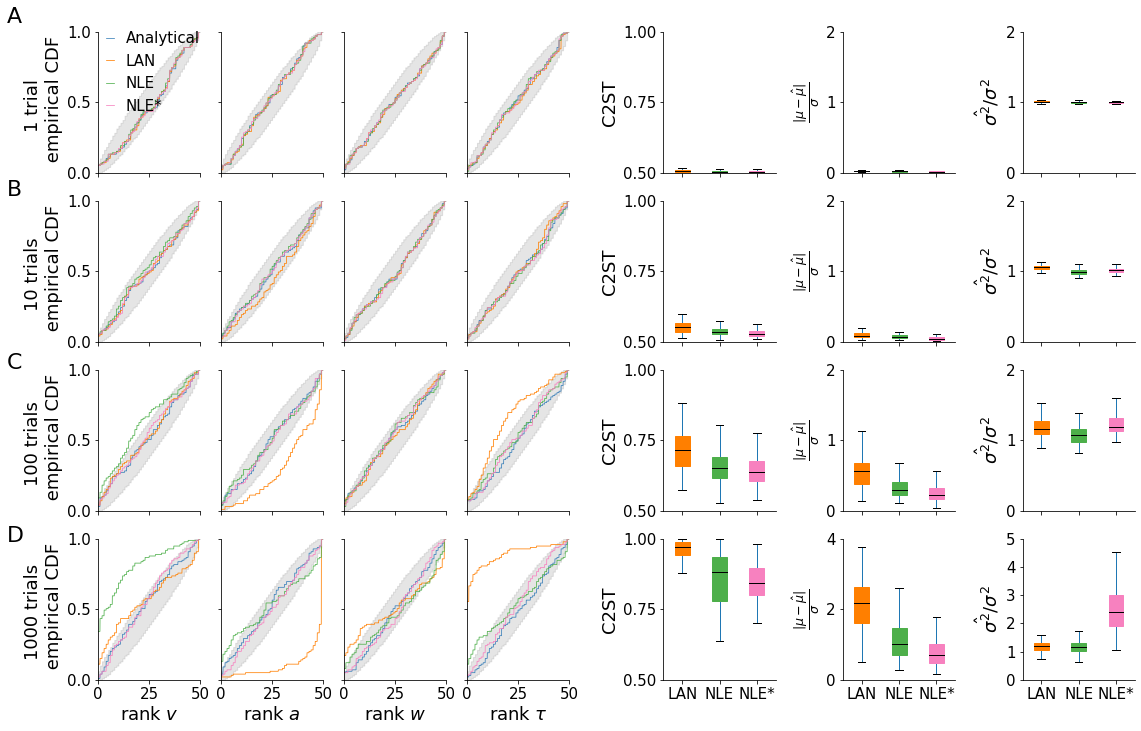

In [244]:
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["font.size"] = 18
num_methods = 4
box_widths = [0.4] * (num_methods - 1)
notch = True
showfliers = False
labels = ["Analytical", "LAN", "NLE", "NLE*"]

fig = plt.figure(figsize=(18, 12))
outer_grid = fig.add_gridspec(1, 2, wspace=0.2, hspace=0.2, width_ratios=[.5, .5])
# Plotting settings

# SBC results
inner_grid = outer_grid[0, 0].subgridspec(len(num_trials_list), 4, wspace=0.2, hspace=.2)
ax1 = inner_grid.subplots(sharey=True, sharex=True)  # Create all subplots for the inner grid.
s = 20
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]
repeats = 50
nbins = 50
from scipy.stats import binom

for kk in range(len(num_trials_list)):
    for ii in range(num_methods):
        for jj in range(4):
            plt.sca(ax1[kk, jj])
            hist, *_ = np.histogram(ranks[kk, :, jj, ii], bins=nbins, density=False)
            histcs = hist.cumsum()
            plt.plot(np.linspace(0, nbins, repeats*nbins), 
                     np.repeat(histcs / histcs.max(), repeats), 
                     label=labels[ii], 
                     color=colors[:num_methods][ii], 
                     alpha=1., 
                     lw=.75)
            if jj==0:
                plt.yticks(np.linspace(0, 1, 3))
                plt.ylabel(f"{[1, 10, 100, 1000][kk]} trial{'s' if kk>0 else ''} \n empirical CDF")
                if kk == 0:
                    plt.legend(loc=2, markerscale=0.5, handlelength=0.5, bbox_to_anchor=(-.05, 1.1))
            else:
                plt.yticks(np.linspace(0, 1, 3), np.linspace(0, 1, 3))
            plt.ylim(0, 1)
            plt.xlim(0, nbins)
            plt.xticks(np.linspace(0, nbins, 3))
            if kk == 3:
                plt.xlabel("rank " + [r"$v$", r"$a$", r"$w$", r"$\tau$"][jj])
            if ii==0:
                # Construct uniform histogram.
                hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
                hbb = hb.cumsum() / hb.sum()

                lower = [binom(N, p=p).ppf(0.005) for p in hbb]
                upper = [binom(N, p=p).ppf(0.995) for p in hbb]

                # Plot grey area with expected ECDF.
                plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                             y1=np.repeat(lower / np.max(lower), repeats), 
                             y2=np.repeat(upper / np.max(lower), repeats), 
                             color="grey", 
                             alpha=0.2)


# posterior metrics
inner_grid = outer_grid[0, 1].subgridspec(len(num_trials_list), 3, wspace=.6, hspace=.2,)
ax2 = inner_grid.subplots(sharex=True, sharey=False)  # Create all subplots for the inner grid.
ylabels = ["C2ST", r"$\frac{|\mu - \hat{\mu}|}{\sigma}$", r"$\hat{\sigma^2} / \sigma^2$"]

for idx, num_trials in enumerate(num_trials_list):
    d = df[df.num_trials == num_trials]
    
    bdict = d.boxplot(column=["C2ST", "MEANERR", "VARERR"], 
                    ax=ax2[idx, :],
                    by=["algorithm"],
                    grid=False, 
                    widths=box_widths,
                    notch=False, 
                    patch_artist=True,
                    showfliers=showfliers,
                    return_type="both",
                    medianprops=dict(color="k"), 
              );
    ticks = [[0.5, 1.0], [0, 2], [0, 2]] if idx < 3 else [[0.5, 1.0], [0, 4], [0.0, 5.]]
    for ii in range(3):
        plt.sca(ax2[idx, ii])
        plt.xlabel("")
        plt.title("")
        plt.ylabel(ylabels[ii])
        
        if ii < 2:
            plt.yticks(np.linspace(ticks[ii][0], ticks[ii][1], 3))
            plt.ylim(*ticks[ii])
        else:
            plt.yticks(np.linspace(ticks[ii][0], ticks[ii][1], 3 if idx < 3 else 6))
            plt.ylim(*ticks[ii])
    plt.suptitle("")
    if idx == 3:
        plt.xticks([1, 2, 3], ["LAN", "NLE", "NLE*"])
    
    ii = 0
    for row_key, (axi,row) in bdict.iteritems():
        ii += 1
        for i,box in enumerate(row['boxes']):
            box.set_color(colors[i+1])

weight = "regular"
fontsize = 22
y1 = 0.91
x1 = 0.03
dx = 0.0
dy = 0.2
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1-2*dy, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-dy, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-3*dy, "D", fontsize=fontsize, fontweight=weight)
# fig.text(x1, y1-0.53, "C", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("SBC-different-trials.png", dpi=300, bbox_inches="tight");

## Plot posterior metrics as lines over trials.

In [245]:
num_methods = 3
c2sts = df.groupby(by=["num_trials", "algorithm"]).C2ST.mean().values.reshape(-1, num_methods)
mers = df.groupby(by=["num_trials", "algorithm"]).MEANERR.mean().values.reshape(-1, num_methods)
vrs = df.groupby(by=["num_trials", "algorithm"]).VARERR.mean().values.reshape(-1, num_methods)
rts = df.groupby(by=["num_trials", "algorithm"]).RT.mean().values.reshape(-1, num_methods)

vc2sts = df.groupby(by=["num_trials", "algorithm"]).C2ST.std().values.reshape(-1, num_methods) / np.sqrt(N)
vmers = df.groupby(by=["num_trials", "algorithm"]).MEANERR.std().values.reshape(-1, num_methods) / np.sqrt(N)
vvrs = df.groupby(by=["num_trials", "algorithm"]).VARERR.std().values.reshape(-1, num_methods)/ np.sqrt(N)
vrts = df.groupby(by=["num_trials", "algorithm"]).RT.std().values.reshape(-1, num_methods)/ np.sqrt(N)

Text(0, 0.5, 'RT')

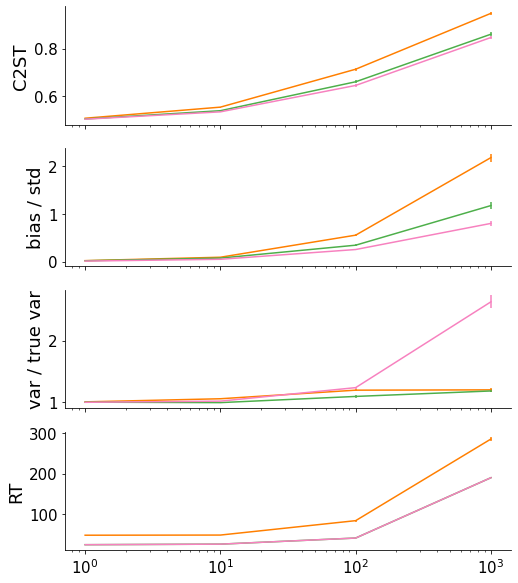

In [246]:
fig, ax = plt.subplots(4, 1, figsize=(8, 10), sharex=True, sharey='row')
plt.sca(ax[0])
for ii in range(num_methods):
    plt.errorbar(df.num_trials.unique(), c2sts[:, ii], vc2sts[:, ii], c=colors[ii+1])
plt.xscale("log");
plt.ylabel("C2ST")

plt.sca(ax[1])
for ii in range(num_methods):
    plt.errorbar(df.num_trials.unique(), mers[:, ii], vmers[:, ii], c=colors[ii+1])
plt.ylabel("bias / std")

plt.sca(ax[2])
for ii in range(num_methods):
    plt.errorbar(df.num_trials.unique(), vrs[:, ii], vvrs[:, ii], c=colors[ii+1])
plt.ylabel("var / true var")

plt.sca(ax[3])
for ii in range(num_methods):
    plt.errorbar(df.num_trials.unique(), rts[:, ii], vrts[:, ii], c=colors[ii+1])
plt.ylabel("RT")

## Save results

- save a dataframe with benchmark results from all trials and LAN, NLE, and NLE-ensemble as algorithms
    - includes mean errors, variance errors and c2sts
- save SBC results for all 4 methods
- save samples as np arrays

In [176]:
ranks.shape

(4, 99, 4, 4)

In [247]:
df.to_csv("data/df_LAN-NLE-NLE*-all-trials-posthoc-metrics-N99.csv")

with open("data/posterior-samples-ANA-LAN-NLE-NLE*-all-trials-posthoc-metrics-N99.p", "wb") as fh:
    pickle.dump(dict(true_params=true_params, 
                     true_samples=true_samples, 
                     lan_samples=lan_samples, 
                     nle_samples=nle_samples,
                     nlee_samples=nlee_samples,
                     ranks=ranks, 
                     meanerr=meanerr,
                     varerr=varerr,
                    ), fh)

## posterior plots for different #trials

In [271]:
obss = [11, 111, 211, 311]
labels = ["LAN", "NLE", "NLE*"]

sss = []
for obs in obss:
    paths = []
    for alg in labels:
        idx = df[df.num_observation==obs].algorithm == alg
        p = df[df.num_observation==obs].loc[idx, "path"].values
        [paths.append(pi) for pi in p]

    sss.append([
        sbibm.get_task("ddm").get_reference_posterior_samples(obs)
         ] + [get_ndarray_from_csv(path+"/posterior_samples.csv.bz2") for path in paths])

print(sbibm.get_task("ddm").get_true_parameters(obs))

tensor([[-0.1677,  1.2243,  0.4250,  1.1840]])


In [273]:
true_samples.shape

(4, 99, 10000, 4)

In [348]:
kw = dict(a=1, b=2)
dict(kw, **dict(b=3))

{'a': 1, 'b': 3}

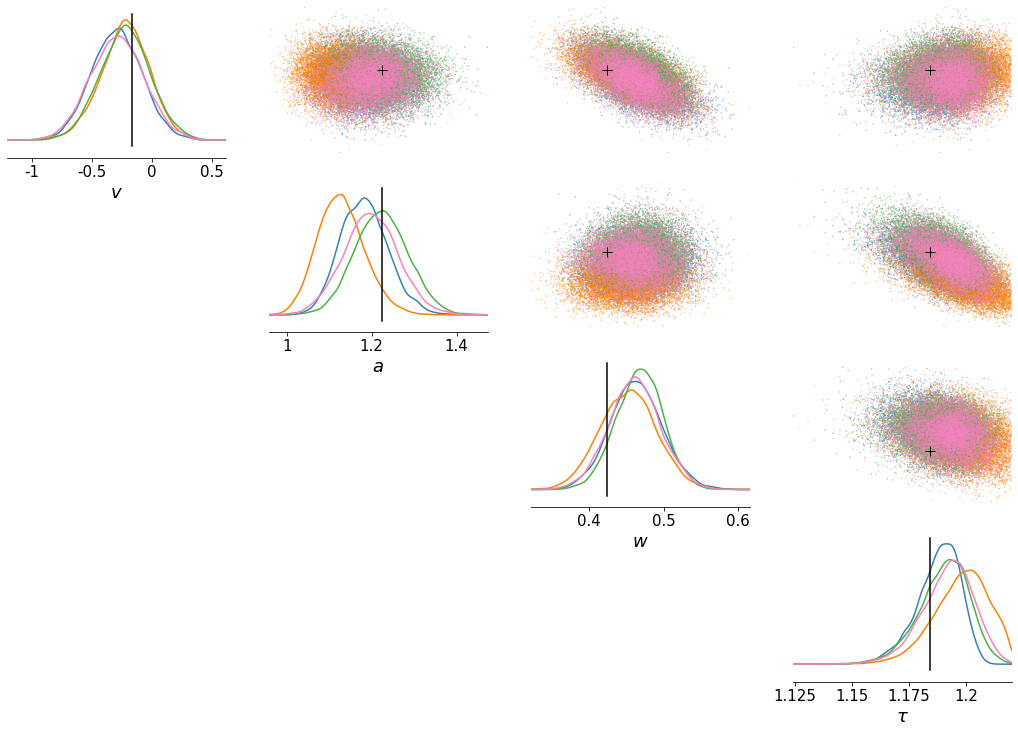

In [346]:
idx = 10
for ii in [2]:
    pairplot([
        true_samples[ii, idx, :, :], 
        lan_samples[ii, idx, :, :], 
        nle_samples[ii, idx, :, :],
        nlee_samples[ii, idx, :, :]
    ],
             points=sbibm.get_task("ddm").get_true_parameters(idx+1), 
#              limits=limits, #[[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]], 
#              ticks = [[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]], 
             samples_colors=colors[:4], 
             diag="kde",
             upper="scatter",
             kde_diag=dict(bw_method="scott", bins=100),
             kde_offdiag=dict(bw_method="scott", bins=100),
             scatter_offdiag=dict(alpha=0.5, s=2),
             contour_offdiag=dict(levels=[.1], percentile=False),
             points_offdiag=dict(marker="+", markersize=10), 
             points_colors=["k"], 
             labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"],
             figsize=(18, 12),
            );

In [339]:
dx = 0.2
limits = torch.stack((sbibm.get_task("ddm").get_true_parameters(idx+1) - dx, 
             sbibm.get_task("ddm").get_true_parameters(idx+1) + dx)).squeeze().T

## Visualize Likelihood for 10 Benchmark observations
We can also visualize the single trial likelihoods for the 10 random observations used in the benchmark.

In [ ]:
ll_true = []
ll_lan = []
ll_nle = []

for ii in range(1, 11):
    
    xo = task.get_observation(ii).reshape(-1, 1)
    test_thetas = prior.sample((1000,))

    # Extract positive RTs and choices for mixed model.
    rs = abs(xo)
    cs = torch.ones_like(rs)
    cs[xo < 0] = 0
  
    ll_true.append(task.get_log_likelihood(test_thetas, data=xo.reshape(1, -1), l_lower_bound=l_lower_bound))

    ll_lan.append(lan_likelihood(test_thetas, 
                                xo, 
                                net=lan_kde, 
                                ll_lower_bound=np.log(l_lower_bound)))
    
    ll_nle.append(nle.log_prob(rs, cs, test_thetas))

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharey=True, sharex=True)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
s = 7
idx = 0
alpha = 1.0
for ii in range(0, 9):
    if ii%3 == 0:
        plt.sca(ax[idx, 0])
    elif ii%3 == 1:
        plt.sca(ax[idx, 1])
    elif ii%3 == 2:
        plt.sca(ax[idx, 2])
        idx += 1

    plt.title(f"Observation {ii+1}")
    
    plt.scatter(ll_true[ii], ll_lan[ii], alpha=alpha, color="C2", s=s)
    plt.scatter(ll_true[ii], ll_nle[ii], alpha=alpha, color="C3", s=s)
    plt.plot(ll_true[ii], ll_true[ii], "k")
    if not ii:
        plt.legend(["Identity", "LAN", "NLE", 
                   ], frameon=False, fontsize=12)
    if ii in [0, 3, 6]:
        plt.ylabel("synthetic log L")
    if ii > 5: 
        plt.xlabel("analytic log L")